# Project 3 Notebook 2 - EDA and Data Cleaning of Praw Data

In [12]:
#EDA imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

In [13]:
# Reading in Praw collected data from my subreddits
praw_data = pd.read_csv('../data/subreddit_data.csv')

In [14]:
# looking at the data set
praw_data.head()

,Unnamed: 0.1,Unnamed: 0,subreddit,selftext,title,created_utc
0,0,0,sleeptrain,It’s been months now of my LO waking at night....,I’m really feeling I’ve hit my limit,1.673296e+09
1,1,1,sleeptrain,So I’m thinking about using the pick up put do...,How do you actually do PUPD?,1.673294e+09
2,2,2,sleeptrain,"Hello, as per the title. Yet again 7.5 mo has ...",Going insane with early wakes.,1.673293e+09
3,3,3,sleeptrain,My LO is 3.5mo and on roughly the same schedul...,How did you extend nap time in crib?,1.673293e+09
4,4,4,sleeptrain,My 2.5 year old has slept through the night wi...,2.5 year old waking throughout night,1.673290e+09


### When I created my first data set I forgot to ignore my indexes when I concatenated and have 2 unnamed columns. I am only focused on the title and subreddit column so I am not going to worry about dropping them. I am going to create a new DF with only the columns I am interested in.

In [15]:
df = praw_data[['subreddit', 'title']]
df.head()

,subreddit,title
0,sleeptrain,I’m really feeling I’ve hit my limit
1,sleeptrain,How do you actually do PUPD?
2,sleeptrain,Going insane with early wakes.
3,sleeptrain,How did you extend nap time in crib?
4,sleeptrain,2.5 year old waking throughout night


In [16]:
# Making sure I do not have any null data
df.isnull().sum()

subreddit    0
title        0
dtype: int64

In [17]:
# Is there a better way to do this?
df_1 = df.copy()

#### I am going to make Attachment Parenting my target. Therefore, I am going to transform Attachment Parenting in my subreddit column to 1 and Sleep Training to 0.

In [18]:
# Changing Subreddit Attachment PArenting to 1 and Sleep Training to 0
df_1['subreddit'] = df['subreddit'].replace({'AttachmentParenting' : 0, 'sleeptrain' : 1})
df_1['title_length'] = df['title'].str.len()
df_1['title_word_count'] = df['title'].str.split().str.len()

df_1.head()

,subreddit,title,title_length,title_word_count
0,1,I’m really feeling I’ve hit my limit,36,7
1,1,How do you actually do PUPD?,28,6
2,1,Going insane with early wakes.,30,5
3,1,How did you extend nap time in crib?,36,8
4,1,2.5 year old waking throughout night,36,6


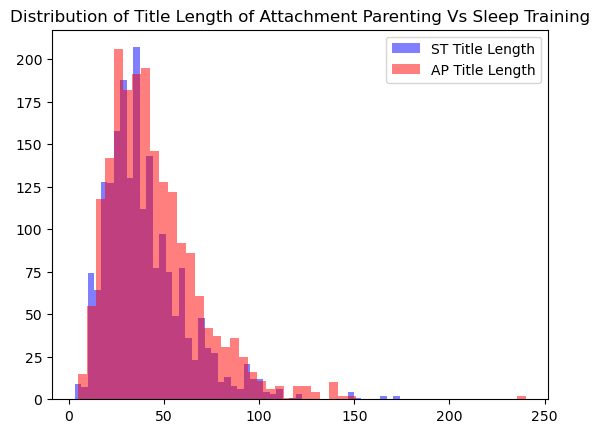

In [19]:
# Plotting Histogram of title length for ST Vs AP
st = df_1[df_1['subreddit'] == 1]
ap = df_1[df_1['subreddit'] == 0]

plt.hist(st['title_length'], color = "b", alpha = 0.5, label = 'ST Title Length', bins = 50)
plt.hist(ap['title_length'] , color = 'r', alpha = 0.5, label = 'AP Title Length', bins = 50)
plt.legend()
plt.title('Distribution of Title Length of Attachment Parenting Vs Sleep Training');

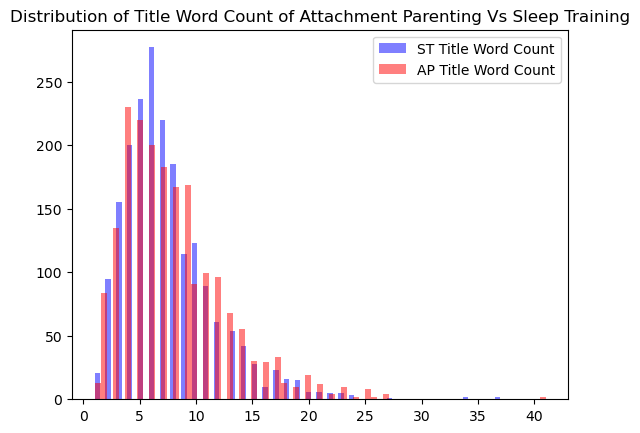

In [20]:
# Plotting Histogram of title word count for ST Vs AP
plt.hist(st['title_word_count'], color = "b", alpha = 0.5, label = 'ST Title Word Count', bins = 75)
plt.hist(ap['title_word_count'] , color = 'r', alpha = 0.5, label = 'AP Title Word Count', bins = 75)
plt.legend()
plt.title('Distribution of Title Word Count of Attachment Parenting Vs Sleep Training');

In [21]:
# Calculating average word count per post for AP and ST
df_1['title_word_count'] = df_1['title'].str.split().str.len()

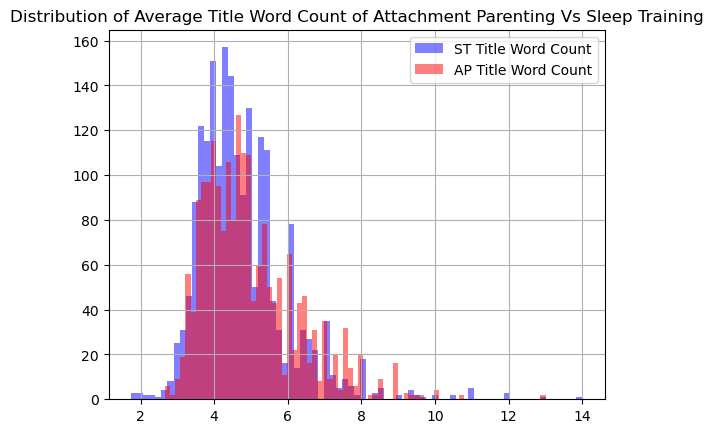

In [22]:
# Histogram of average worc count for AP vs ST
st['title'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = "b", alpha = 0.5, label = 'ST Title Word Count', bins = 75)
ap['title'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = 'r', alpha = 0.5, label = 'AP Title Word Count', bins = 75)
plt.legend()
plt.title('Distribution of Average Title Word Count of Attachment Parenting Vs Sleep Training');

### The title length for AP and ST are pretty close. The word count and average word count for titles have a little more difference but nothing glaring. I am going to vectorize the text using TF-IDF vecotrizer to see if I can find any larger difefrences between the data sets for modeling.

In [23]:
# Creating series of just titles for each ST and AP to transform using TF-IDF Vectorizer
st_corpus = st['title']
ap_corpus = ap['title']
st_corpus

0                    I’m really feeling I’ve hit my limit
1                            How do you actually do PUPD?
2                          Going insane with early wakes.
3                    How did you extend nap time in crib?
4                    2.5 year old waking throughout night
                              ...                        
2982    Almost 7month old has stopped napping - what a...
2983                   Talk to me about the Ferber Method
2984                        Should I bother or just wait?
2985    How to handle feedings when increasing ww and ...
2986    6.5mo wake windows are now almost 4 hrs, what’...
Name: title, Length: 1994, dtype: object

In [24]:
# Instantiating the Vectorizer
tvec = TfidfVectorizer()

In [25]:
# Fitting tvec and transorming the text, I am fitting on my two Subreddit DFs separatelty to esse
tvec.fit(st_corpus, ap_corpus)
st_x = tvec.transform(st_corpus)
ap_x = tvec.transform(ap_corpus)

In [26]:
# Creating dataframes from the vectorized text
st_x = pd.DataFrame(st_x.todense(), columns = tvec.get_feature_names_out())
ap_x = pd.DataFrame(ap_x.todense(), columns = tvec.get_feature_names_out())

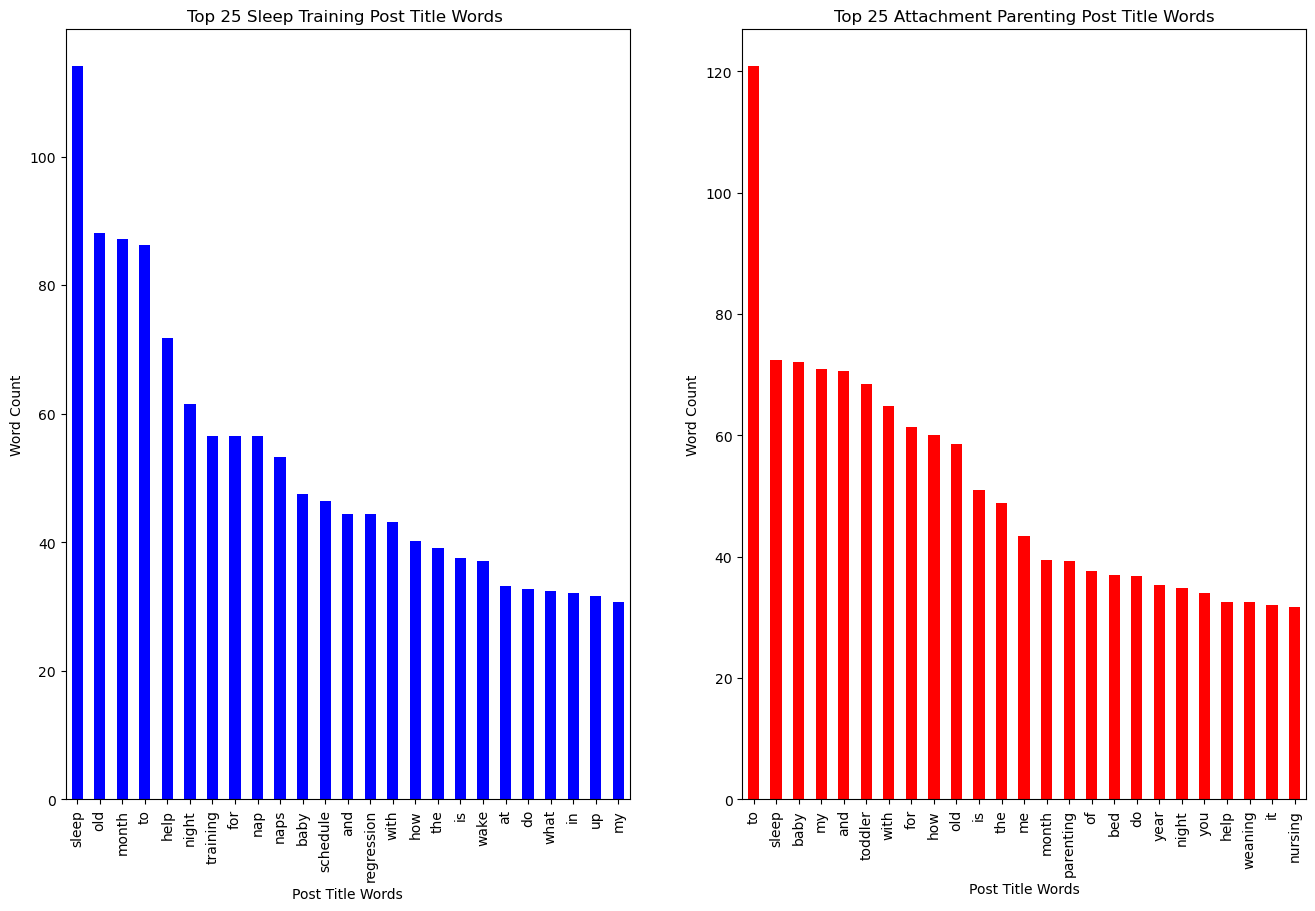

In [38]:
# Looking at the top 25 words for AP and ST
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 Sleep Training Post Title Words ')
axes[1].set_title('Top 25 Attachment Parenting Post Title Words')
axes[0].set_xlabel('Post Title Words')
axes[1].set_xlabel('Post Title Words')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');

### Words from the title of Sleep Training and Attachment Parenting Subreddit seem to show up quite a bit in each of their respective subreddits so I will remove the words of the Subreddit title from each.

In [426]:
shared_words(st_x, ap_x)

(['sleep',
  'old',
  'month',
  'to',
  'help',
  'night',
  'for',
  'baby',
  'and',
  'with',
  'how',
  'the',
  'is',
  'do',
  'my'],
 15)

In [364]:
# Removing Subreddit title words from both ST and AP titles
words_to_remove = '|'.join(['sleep', 'train', 'training', 'attachment', 'attach', 'parenting', 'parent','Sleep', 'Train', 'Training', 'Attachment', 'Attach', 'Parenting', 'Parent'])
st_titlewords_removed= st_corpus.str.replace(words_to_remove, '', regex = True)
ap_titlewords_removed = ap_corpus.str.replace(words_to_remove, '', regex = True)

In [365]:
#instantiating the vectorizer 
tvec = TfidfVectorizer()

In [366]:
# Fitting tvec and transorming the text
tvec.fit(st_titlewords_removed, ap_titlewords_removed)
st_titlewords_removed_x = tvec.transform(st_titlewords_removed)
ap_titlewords_removed_x = tvec.transform(ap_titlewords_removed)

In [367]:
# Creating dataframes from the vectorized text
st_titlewords_removed_x = pd.DataFrame(st_titlewords_removed_x.todense(), columns = tvec.get_feature_names_out())
ap_titlewords_removed_x = pd.DataFrame(ap_titlewords_removed_x.todense(), columns = tvec.get_feature_names_out())

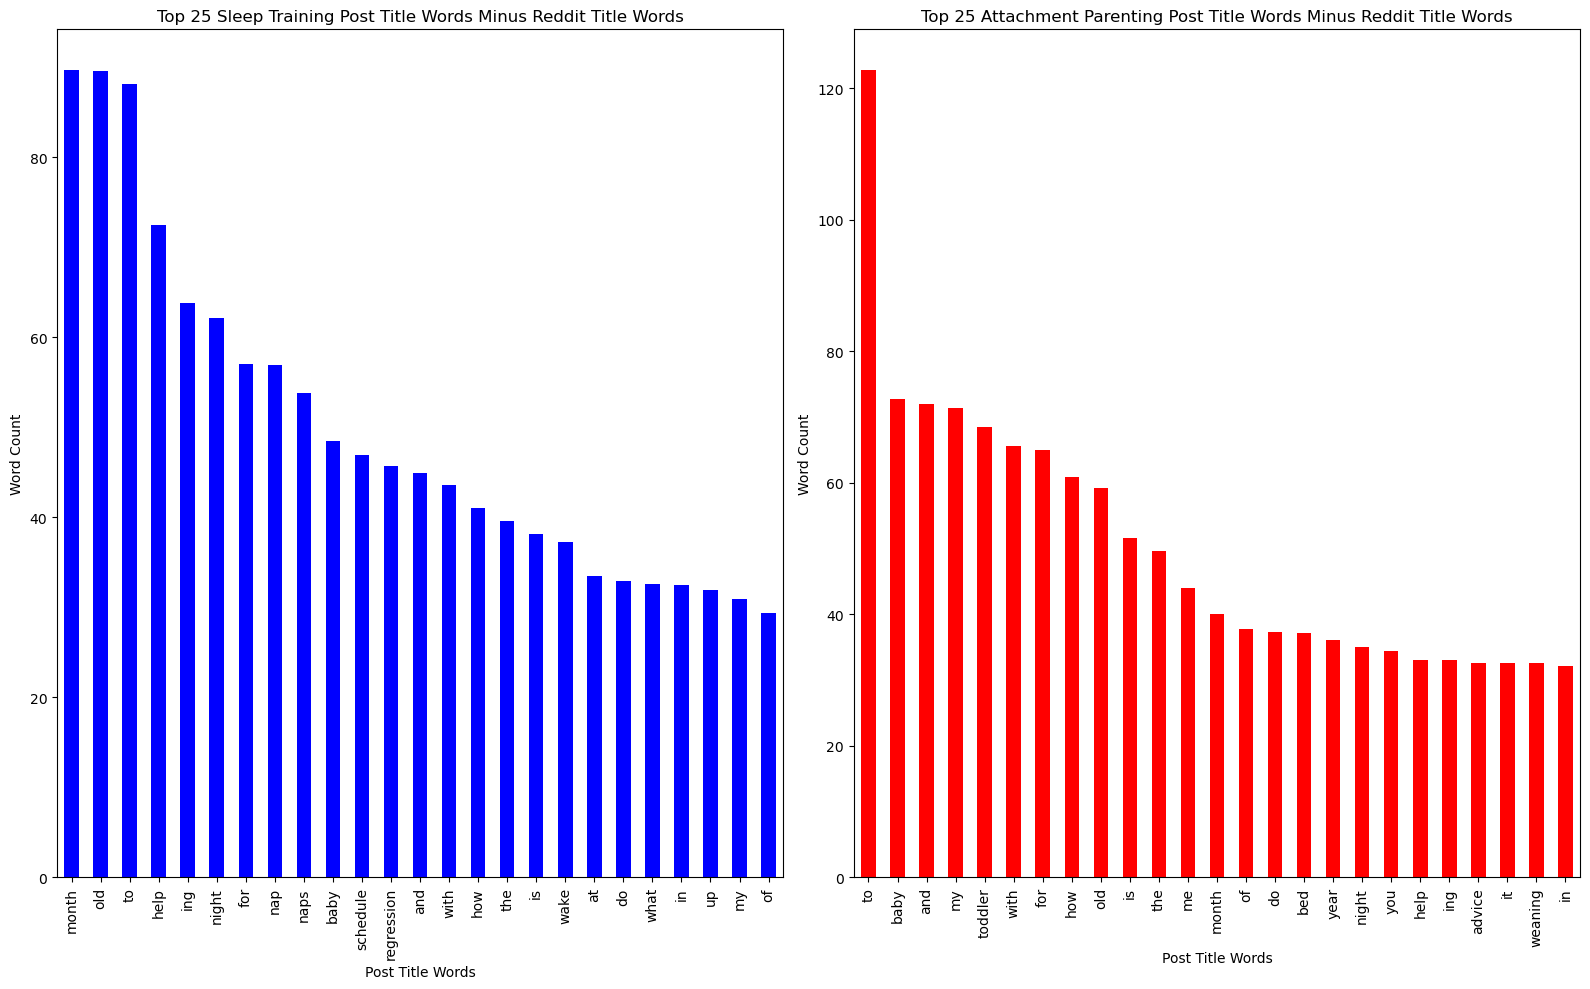

In [421]:
# Looking at the top 25 words for AP and ST now that the Subreddit title words have been removed
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 Sleep Training Post Title Words Minus Reddit Title Words')
axes[1].set_title('Top 25 Attachment Parenting Post Title Words Minus Reddit Title Words')
axes[0].set_xlabel('Post Title Words')
axes[1].set_xlabel('Post Title Words')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');
plt.tight_layout()
plt.savefig('../project-3/Images/top_25_no_title_words.png')

### Over half of the top 25 words in both Sleep Training and Attachment Parenting Title Posts are stop words ('to', 'for', 'and', 'with', 'how', 'the', 'is', 'do', 'and', 'in', and 'of'). Next I will remove stop words from both sets of titles and see what the top words are. 

In [369]:
# Creating a function that takes in 2 dataframes, makes a list of the top 25 words 
# of each and identifies any words that are shared between those 2 lists
def shared_words (df_1, df_2):
    # Calculating the top 25 words from each df
    df_1_top_25 = df_1.sum().sort_values(ascending = False)[0:25]
    df_2_top_25 = df_2.sum().sort_values(ascending = False)[0:25]
    # Putting the series into a dataframe and creating a new indesx to access the word column
    df_1_top_25 =pd.DataFrame(df_1_top_25).reset_index()
    df_2_top_25 =pd.DataFrame(df_2_top_25).reset_index()
    # Creating lists of the top 25 words from each DF
    df_1_list = []
    df_2_list = []
    for i in df_1_top_25['index']:
        df_1_list.append(i)
    for i in df_2_top_25['index']:
        df_2_list.append(i)
    # Looping through both lists to find words present in both and returning that list
    in_both = []
    for i in df_1_list:
        if i in df_2_list:
            in_both.append(i) 
    return in_both, len(in_both)


In [370]:
shared_words(st_titlewords_removed_x, ap_titlewords_removed_x)

(['month',
  'old',
  'to',
  'help',
  'ing',
  'night',
  'for',
  'baby',
  'and',
  'with',
  'how',
  'the',
  'is',
  'do',
  'in',
  'my',
  'of'],
 17)

In [371]:
# Instantiating the vectorizer with NLTK stop words removed
tvec = TfidfVectorizer(stop_words=stopwords.words('english'))

In [372]:
# Fitting tvec and transorming the text
tvec.fit(st_titlewords_removed, ap_titlewords_removed)
st_title_and_s_words_removed_x = tvec.transform(st_titlewords_removed)
ap_title_and_s_words_removed_x = tvec.transform(ap_titlewords_removed)

In [373]:
# Creating dataframes from the vectorized text
st_title_and_s_words_removed_x = pd.DataFrame(st_title_and_s_words_removed_x.todense(), columns = tvec.get_feature_names_out())
ap_title_and_s_words_removed_x = pd.DataFrame(ap_title_and_s_words_removed_x.todense(), columns = tvec.get_feature_names_out())

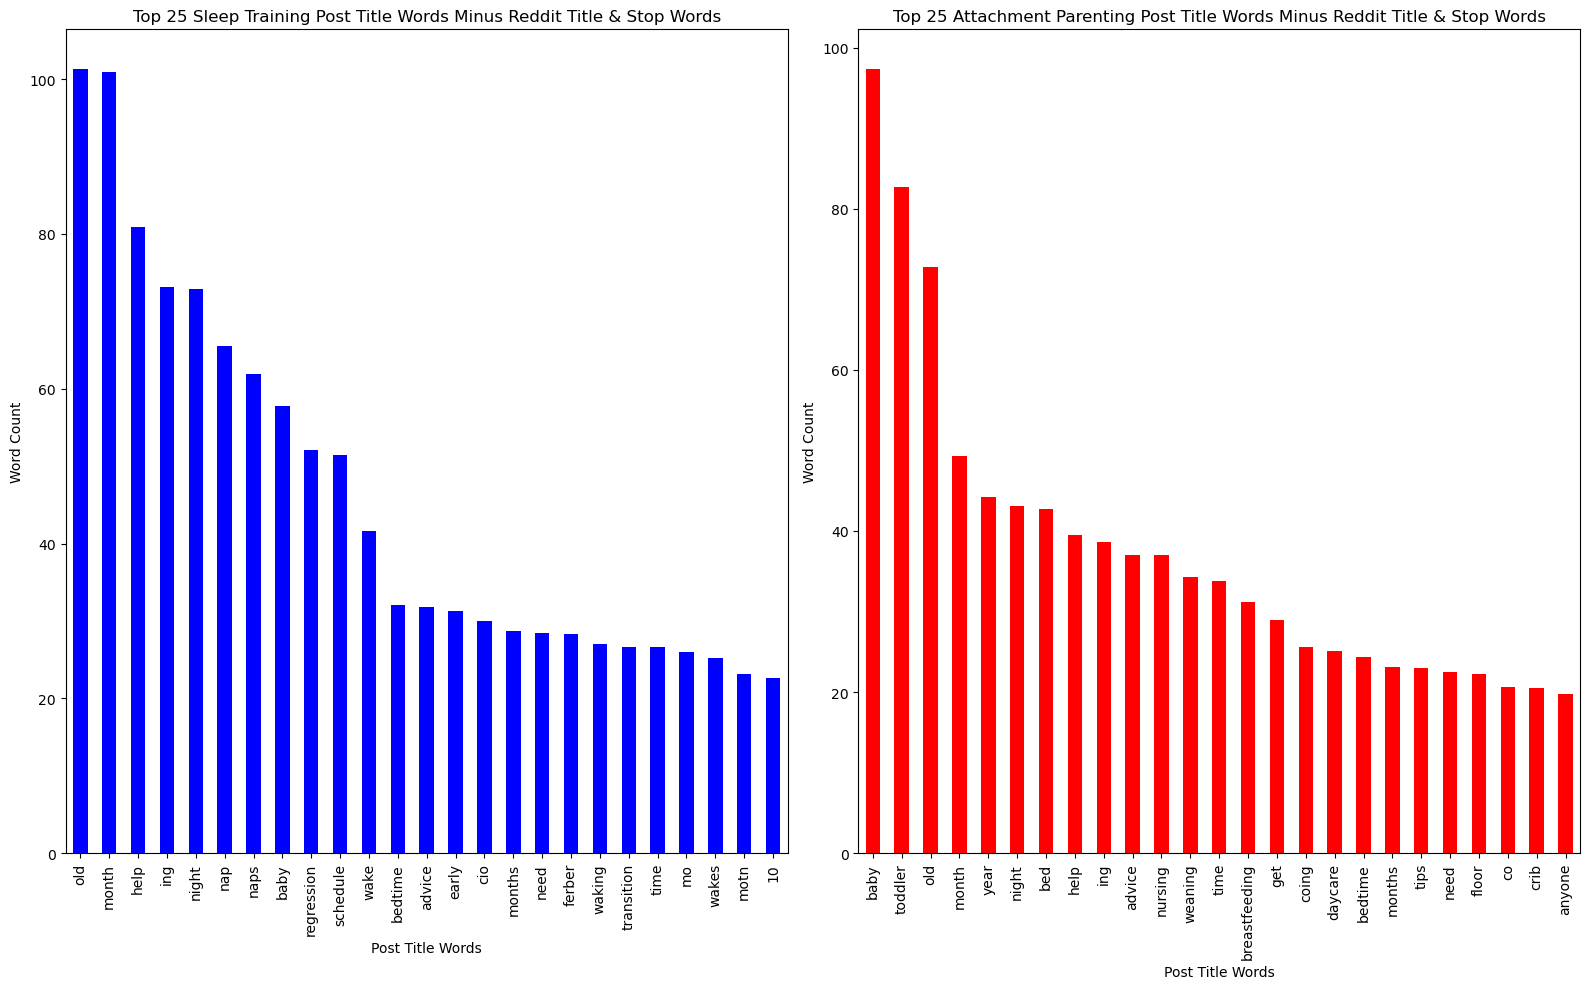

In [422]:
# Looking at the top 25 words for AP and ST now that the Subreddit title words 
# and NLTK stop words have been removed

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 Sleep Training Post Title Words Minus Reddit Title & Stop Words')
axes[1].set_title('Top 25 Attachment Parenting Post Title Words Minus Reddit Title & Stop Words')
axes[0].set_xlabel('Post Title Words')
axes[1].set_xlabel('Post Title Words')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');
plt.tight_layout()
plt.savefig('../project-3/Images/top_25_no_stop_words.png')

### Removing the stop words did change the total number of top 25 words that both subreddits had in common but they still have several that appear in the top 25 of both ('old', 'month', 'help', 'ing', 'night', 'baby', 'bedtime', 'advice', 'months', 'need', 'time'). I am not too upset about that as I want challenge my model in differentiating between the two Subreddits. I also see instances of nap and naps or month and months so I will lemmitize the words to reduce these repeats.

In [375]:
# Running function to look for same words in each ST and AP top 25
shared_words(st_title_and_s_words_removed_x, ap_title_and_s_words_removed_x)

(['old',
  'month',
  'help',
  'ing',
  'night',
  'baby',
  'bedtime',
  'advice',
  'months',
  'need',
  'time'],
 11)

### Testing the NLTK lemmatizer on the words I identified above

In [376]:
# Instantiating the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize Single Word
print(lemmatizer.lemmatize("naps"))

nap


In [377]:
# Lemmatize Single Word
print(lemmatizer.lemmatize("months"))

month


### I am not surprised these work as the lemmatizer is designed to remove what it sees a plurals. I am tempted to stem the words as well to change words like helping to help, however, several of the words in my top 25 take on a new meaning when stemmed. For instance, waking and wake generally can be used in the same context. But here wake refers to wake windows which are a specified range of time that a baby or toddler is awake and waking would refer to a baby or toddler waking up.

In [378]:
ap_titlewords_removed

998                        Our angry screaming 5 year old
999                         Night weaning support please!
1000                              18 month ing on her own
1001                      Favorite toddler weaning books?
1002                        Potty accidents in 5 year old
                              ...                        
3977    Dealing with a preference for just one  overni...
3978                                    Alfie kohn  style
3979                         Can someone explain possums?
3980         10 month old baby is fighting her second nap
3981                  How to handle the nursery at church
Name: title, Length: 1988, dtype: object

In [379]:
st_titlewords_removed

0                    I’m really feeling I’ve hit my limit
1                            How do you actually do PUPD?
2                          Going insane with early wakes.
3                    How did you extend nap time in crib?
4                    2.5 year old waking throughout night
                              ...                        
2982    Almost 7month old has stopped napping - what a...
2983                   Talk to me about the Ferber Method
2984                        Should I bother or just wait?
2985    How to handle feedings when increasing ww and ...
2986    6.5mo wake windows are now almost 4 hrs, what’...
Name: title, Length: 1994, dtype: object

In [380]:
# Custom tokenizing - using the lemmatizer function we made during our breakfast hour 
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in text.split(" ")]

In [381]:
# apply same pre-processing as posts to stopwords- this prevents my tokenizer from returning errors 
# that it no longer recognizes the stop words in my text that have been lemmatized
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w) for w in stopwords.words('english')]

In [382]:
# Instantiating the vectorizer with NLTK stop words removed and words lemmatized
tvec = TfidfVectorizer(stop_words=lem_stopwords, tokenizer = my_lemmatizer)

In [383]:
# Fitting tvec and transorming the text
tvec.fit(st_titlewords_removed, ap_titlewords_removed)
st_t_and_s_removed_lemmatized_x = tvec.transform(st_titlewords_removed)
ap_t_and_s_removed_lemmatized_x = tvec.transform(ap_titlewords_removed)

/Users/scottaskinosie/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [384]:
# Creating dataframes from the vectorized text
st_t_and_s_removed_lemmatized_x = pd.DataFrame(st_t_and_s_removed_lemmatized_x.todense(), columns = tvec.get_feature_names_out())
ap_t_and_s_removed_lemmatized_x = pd.DataFrame(ap_t_and_s_removed_lemmatized_x.todense(), columns = tvec.get_feature_names_out())

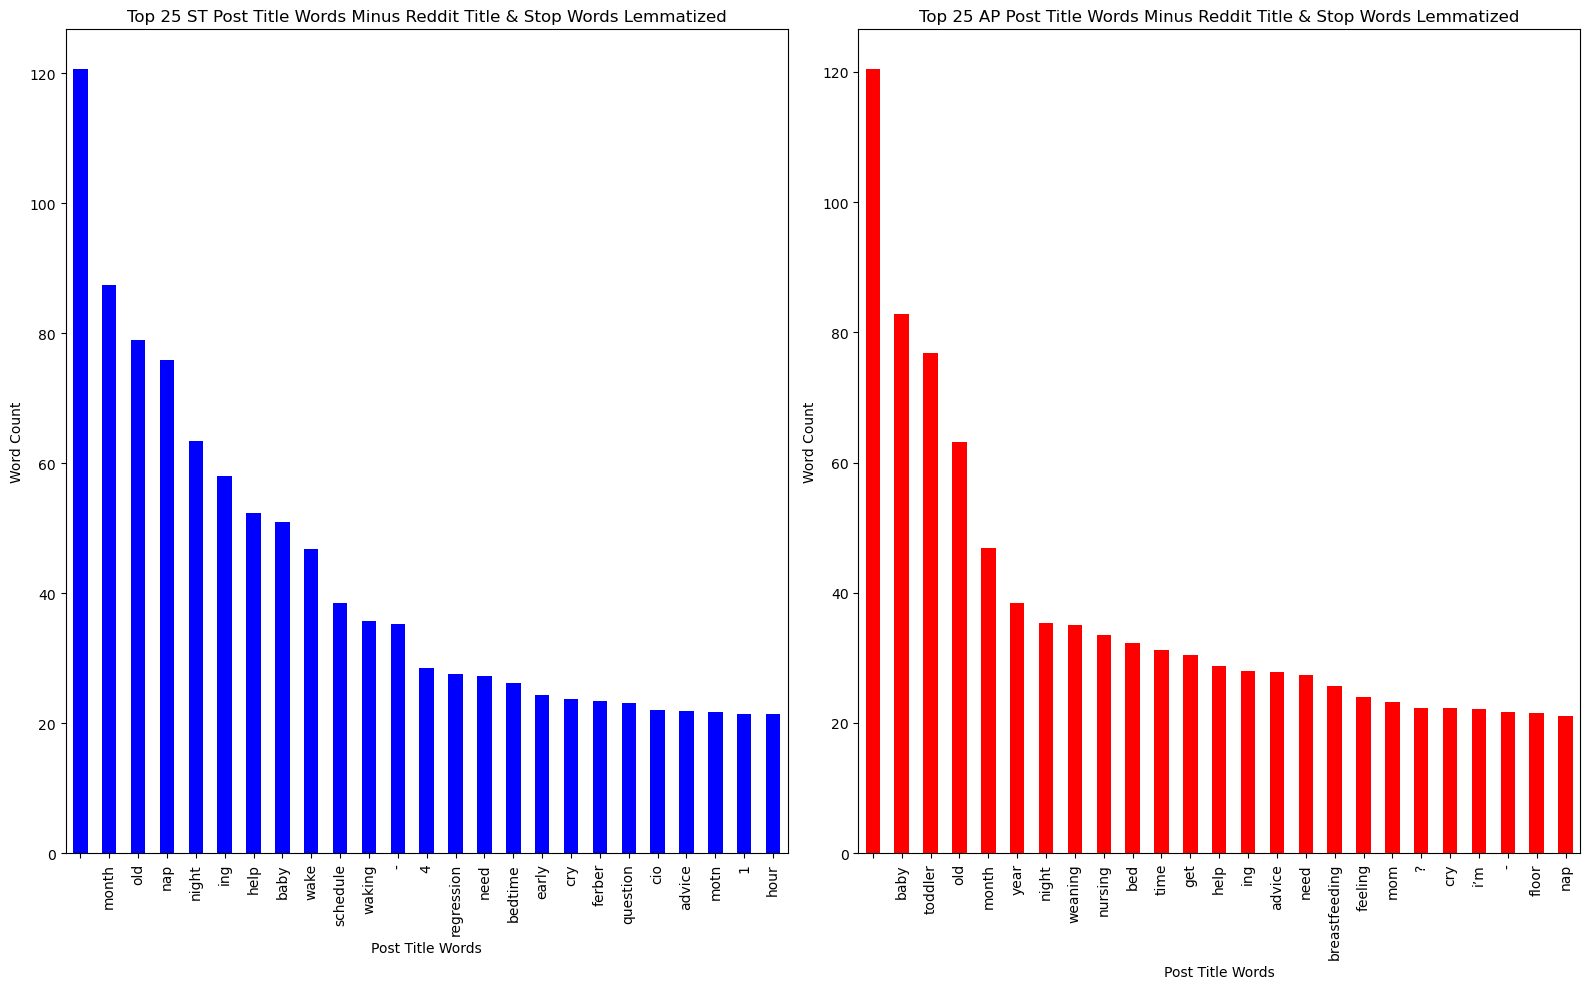

In [423]:
# Looking at the top 25 words for AP and ST now that the Subreddit title words, 
# NLTK stop words have been removed and the words hav ebeen lemmatized

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 ST Post Title Words Minus Reddit Title & Stop Words Lemmatized')
axes[1].set_title('Top 25 AP Post Title Words Minus Reddit Title & Stop Words Lemmatized')
axes[0].set_xlabel('Post Title Words')
axes[1].set_xlabel('Post Title Words')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');
plt.tight_layout()
plt.savefig('../project-3/Images/top_25_lemmatized.png')

### Lemmatizing seems to have made things a little more challenging for EDA and modeling. I have more words in common between my categories than I did before lemmatizing and I now have spaces as the most prominent character in both categories. This is most likely the result of replacing the Subreddit Title Words with "" earlier. I also now see more special characters and numbers in the list of top 25 words. I plan on modeling without lemmatizing but I may try it if I have time. For now I am going to continue on with 2 and 3 ngrams. 

In [386]:
# Running function to look for same words in each ST and AP top 25
shared_words(st_t_and_s_removed_lemmatized_x, ap_t_and_s_removed_lemmatized_x)

(['',
  'month',
  'old',
  'nap',
  'night',
  'ing',
  'help',
  'baby',
  '-',
  'need',
  'cry',
  'advice'],
 12)

In [387]:
# Instantiating the vectorizer with NLTK stop words removed and 2grams
tvec_2grams = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range = (2,2))

In [388]:
# Fitting tvec_2grams and transorming the text
tvec_2grams.fit(st_titlewords_removed, ap_titlewords_removed)
st_notw_nosw_x_2grams = tvec_2grams.transform(st_titlewords_removed)
ap_notw_nosw_x_2grams = tvec_2grams.transform(ap_titlewords_removed)

In [389]:
# Creating dataframes from the vectorized text
st_notw_nosw_x_2grams = pd.DataFrame(st_notw_nosw_x_2grams.todense(), columns = tvec_2grams.get_feature_names_out())
ap_notw_nosw_x_2grams = pd.DataFrame(ap_notw_nosw_x_2grams.todense(), columns = tvec_2grams.get_feature_names_out())

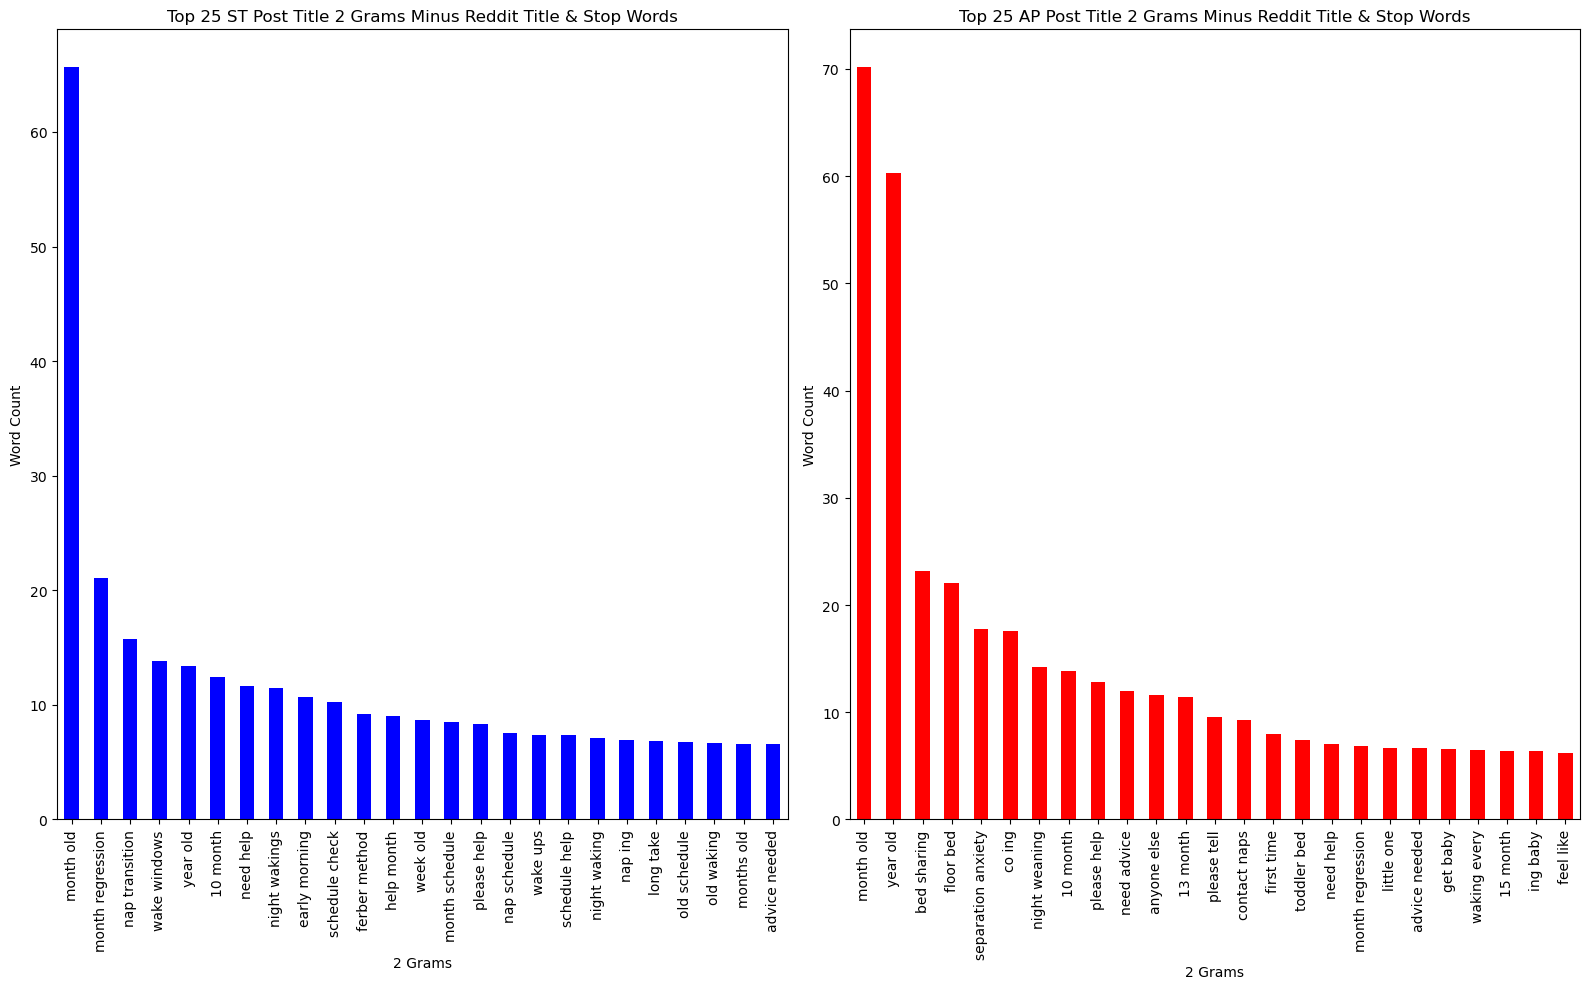

In [424]:
# Looking at the top 25 words for AP and ST now that the Subreddit title words, 
# NLTK stop words have been removed and converted to 2grams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_notw_nosw_x_2grams.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_notw_nosw_x_2grams.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 ST Post Title 2 Grams Minus Reddit Title & Stop Words')
axes[1].set_title('Top 25 AP Post Title 2 Grams Minus Reddit Title & Stop Words')
axes[0].set_xlabel('2 Grams')
axes[1].set_xlabel('2 Grams')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');
plt.tight_layout()
plt.savefig('../project-3/Images/top_25_2grams.png')

### The two grams have further separated my two Subreddit Title Words from each other. I now have gone down to 7 from my previous least of 11. I believe this may make my model stronger but i want to go a little deeper and see if 3 grams makes a difference.

In [391]:
# Running function to look for same words in each ST and AP top 25
shared_words(st_notw_nosw_x_2grams, ap_notw_nosw_x_2grams)

(['month old',
  'month regression',
  'year old',
  '10 month',
  'need help',
  'please help',
  'advice needed'],
 7)

In [392]:
# Instantiating the vectorizer with NLTK stop words removed and 2grams
tvec_3grams = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range = (3,3))

In [393]:
# Fitting tvec_3grams and transorming the text
tvec_3grams.fit(st_titlewords_removed, ap_titlewords_removed)
st_notw_nosw_x_3grams = tvec_3grams.transform(st_titlewords_removed)
ap_notw_nosw_x_3grams = tvec_3grams.transform(ap_titlewords_removed)

In [394]:
# Creating dataframes from the vectorized text
st_notw_nosw_x_3grams = pd.DataFrame(st_notw_nosw_x_3grams.todense(), columns = tvec_3grams.get_feature_names_out())
ap_notw_nosw_x_3grams = pd.DataFrame(ap_notw_nosw_x_3grams.todense(), columns = tvec_3grams.get_feature_names_out())

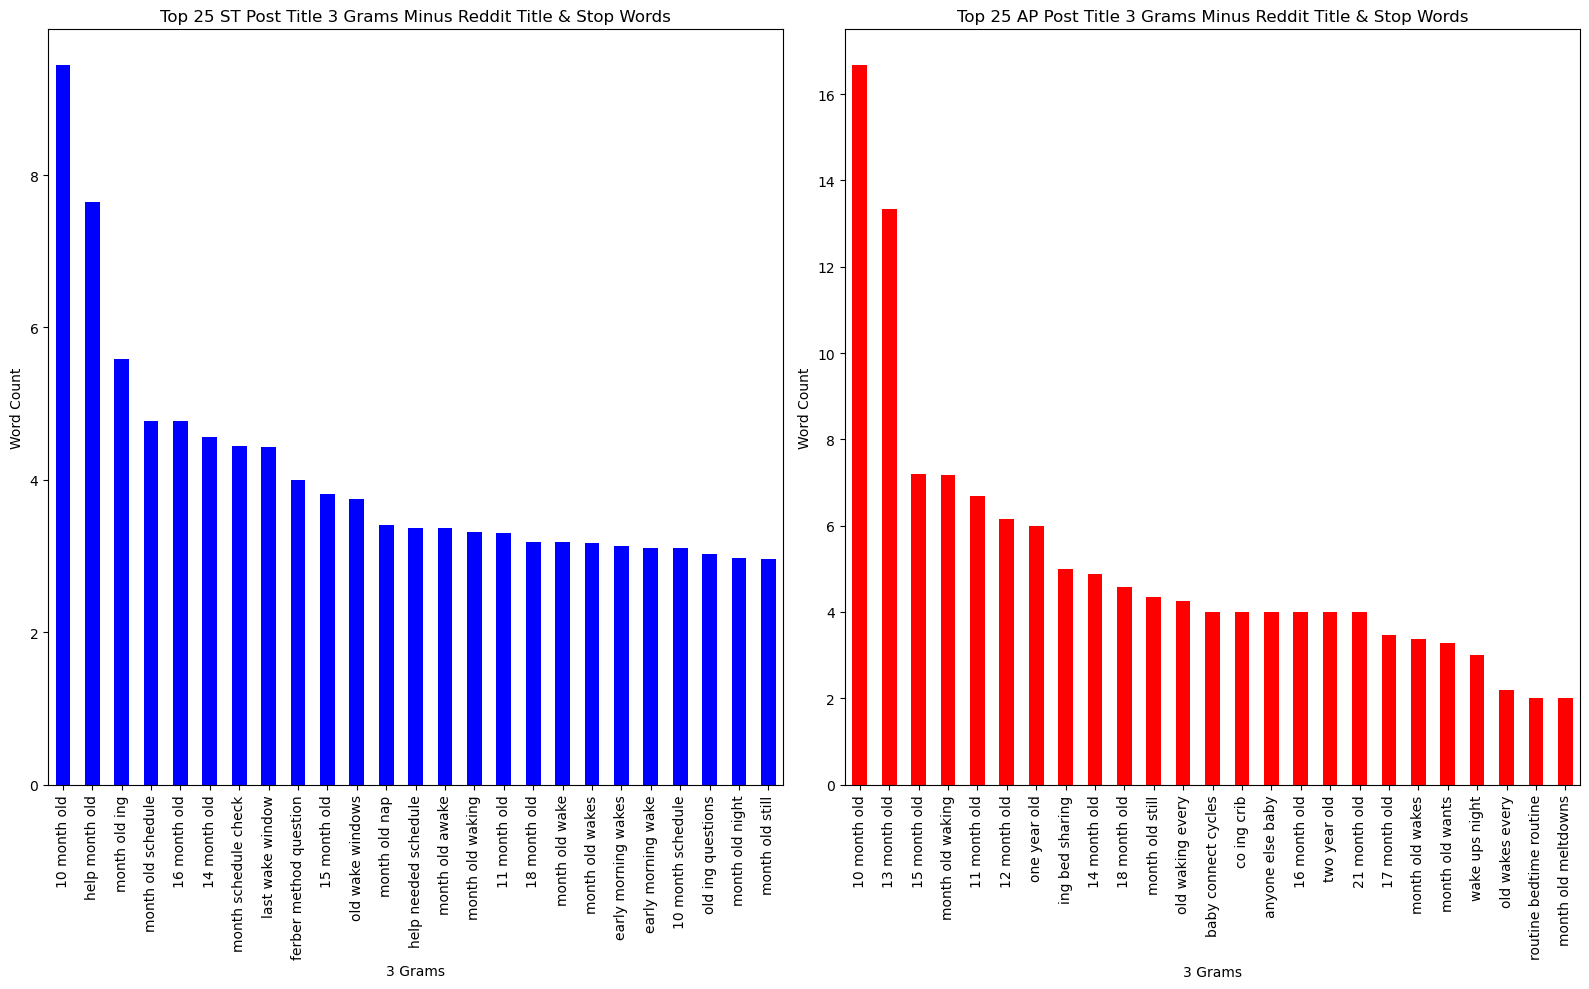

In [425]:
# Looking at the top 25 words for AP and ST now that the Subreddit title words, 
# NLTK stop words have been removed and converted to 3grams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharex=False)
st_notw_nosw_x_3grams.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0], color='b', kind='bar')
ap_notw_nosw_x_3grams.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1], color='r', kind='bar')

axes[0].set_title('Top 25 ST Post Title 3 Grams Minus Reddit Title & Stop Words')
axes[1].set_title('Top 25 AP Post Title 3 Grams Minus Reddit Title & Stop Words')
axes[0].set_xlabel('3 Grams')
axes[1].set_xlabel('3 Grams')
axes[0].set_ylabel('Word Count')
axes[1].set_ylabel('Word Count');
plt.tight_layout()
plt.savefig('../project-3/Images/top_25_3grams.png')

### The results of the 3 grams surprise me, as have several other steps in the EDA and preprocessing that I have completed. I was expecting the 3 grams to further separate my 2 Subreddit categories. I believed this because the 2 grams gave me less top 25 words in common so I assumed that adding an additional word to each gram would further separate the 2. However, I see now that adding the third word actually made the 2 Subreddit categories look more similar. I imagine that if a model saw this it would have a more difficult time parsing the two and would result in a poorer score. I have seen this in some of my practice but not fully understood the concept until now. I would like to confirm my hypothesis here when I move onto modeling. I will try  models with both 2 grams and 3 grams to confirm that the 2 grams have a better score. 

In [396]:
# Running function to look for same words in each ST and AP top 25
shared_words(st_notw_nosw_x_3grams, ap_notw_nosw_x_3grams)

(['10 month old',
  '16 month old',
  '14 month old',
  '15 month old',
  'month old waking',
  '11 month old',
  '18 month old',
  'month old wakes',
  'month old still'],
 9)

### Now I would like to run a few of the EDA steps above using the cvec vectorizer to see if I get similar results and so that I can determine the best vectorizer to use with my model. I will use the same hyperparameters to keep the experiment consistent and reduce my independent variable to just cvec Vs tvec.

### Running cvec on unmodified title words for comparison against tvec

In [397]:
# Instantiating the Vectorizer for the unmodified title words
cvec = CountVectorizer()

In [398]:
# Fitting tvec and transorming the text
cvec.fit(st_corpus, ap_corpus)
cvec_st_x = cvec.transform(st_corpus)
cvec_ap_x = cvec.transform(ap_corpus)

In [399]:
# Creating dataframes from the vectorized text
cvec_st_x = pd.DataFrame(cvec_st_x.todense(), columns = cvec.get_feature_names_out())
cvec_ap_x = pd.DataFrame(cvec_ap_x.todense(), columns = cvec.get_feature_names_out())

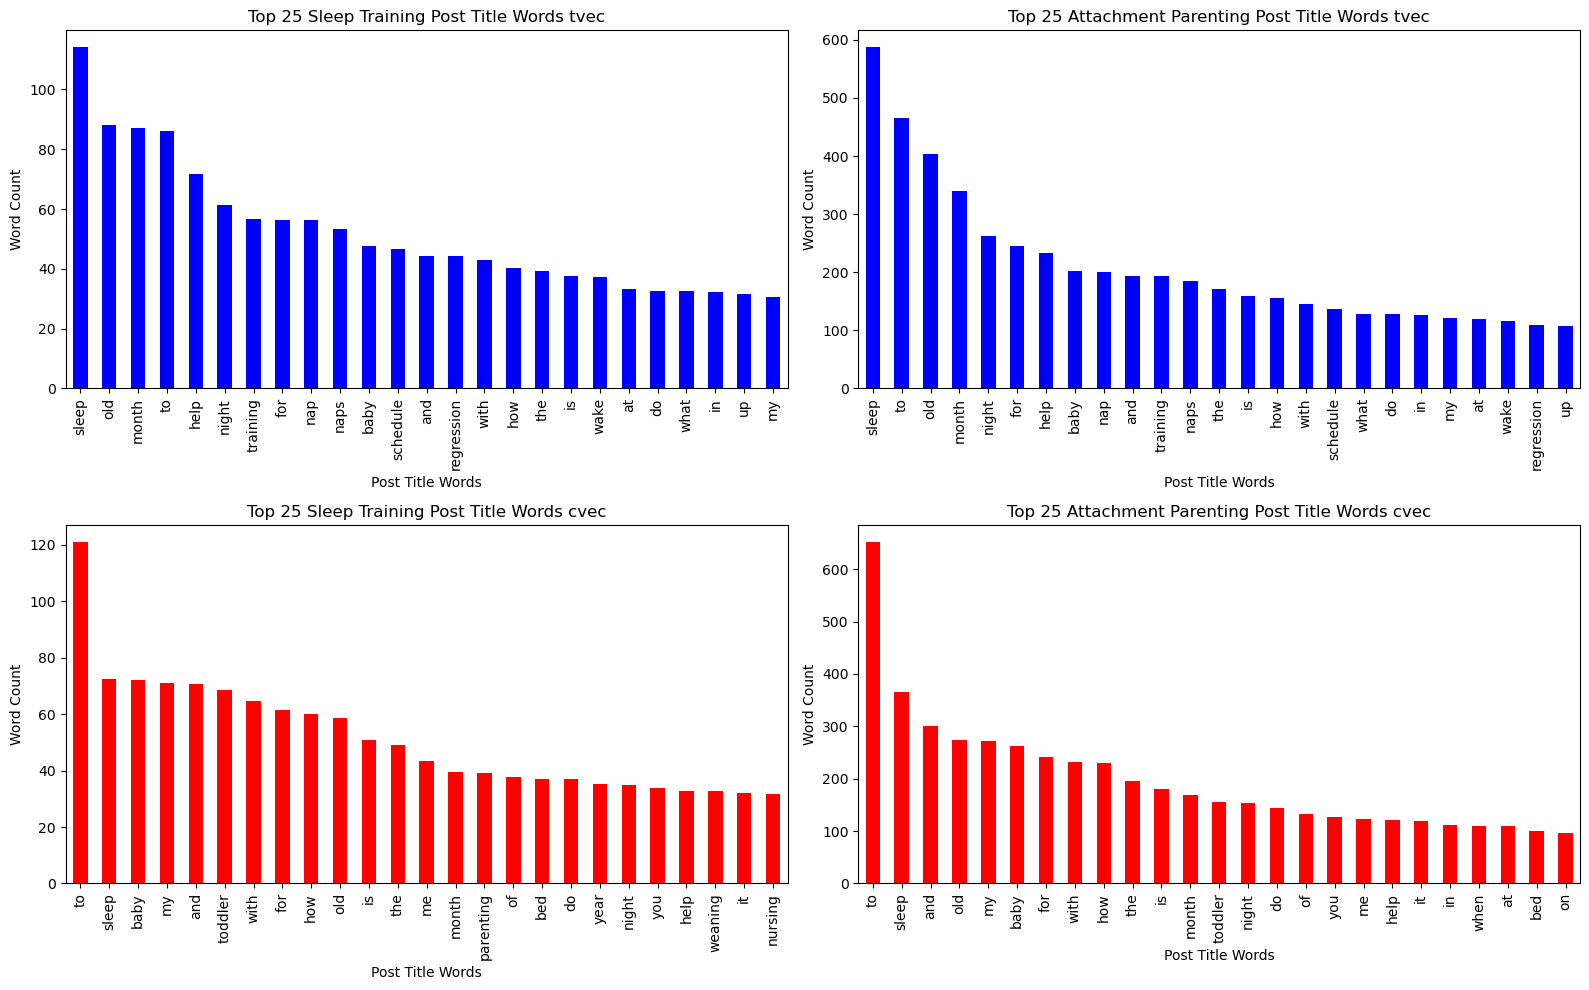

In [400]:
# Looking at the top 25 words for AP tvec and ST tvec Vs AP cvec and ST cvec
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=False)
st_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,0], color='b', kind='bar')
ap_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,0], color='r', kind='bar')

cvec_st_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,1], color='b', kind='bar')
cvec_ap_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,1], color='r', kind='bar')

axes[0,0].set_title('Top 25 Sleep Training Post Title Words tvec')
axes[0,1].set_title('Top 25 Attachment Parenting Post Title Words tvec')
axes[0,0].set_xlabel('Post Title Words')
axes[0,1].set_xlabel('Post Title Words')
axes[0,0].set_ylabel('Word Count')
axes[0,1].set_ylabel('Word Count')

axes[1,0].set_title('Top 25 Sleep Training Post Title Words cvec')
axes[1,1].set_title('Top 25 Attachment Parenting Post Title Words cvec')
axes[1,0].set_xlabel('Post Title Words')
axes[1,1].set_xlabel('Post Title Words')
axes[1,0].set_ylabel('Word Count')
axes[1,1].set_ylabel('Word Count')
plt.tight_layout();

### The differences between cvec and tvec for my title top 25 word counts are striking but I am not suer if they are significant. The cvec in both Subreddit categories yielded a much higher word count but the words themselves were the same, albeit in a different order, for the sleep training Subreddit category whereas the attachment parenting Subreddit category had 21 of the 25 top words in common. I am going to delve deeper into the differences between the two and probably use them both in my modeling to see how the categorizing changes as a result of these differences.

As a side note, during our hackathon last week I noticed subtle differences in the performance of identical models using cvec Vs tvec and now I think I see why. The vectorization, although they share similar goals, follow different processes and yield somewhat different results. I am looking forward to running further tests to see how else the two differ.

In [401]:
# Running function to look for same words in each ST cvec and ST tvec top 25
shared_words(st_x, cvec_st_x)

(['sleep',
  'old',
  'month',
  'to',
  'help',
  'night',
  'training',
  'for',
  'nap',
  'naps',
  'baby',
  'schedule',
  'and',
  'regression',
  'with',
  'how',
  'the',
  'is',
  'wake',
  'at',
  'do',
  'what',
  'in',
  'up',
  'my'],
 25)

In [402]:
# Running function to look for same words in each AP cvec and AP tvec top 25
shared_words(ap_x, cvec_ap_x)

(['to',
  'sleep',
  'baby',
  'my',
  'and',
  'toddler',
  'with',
  'for',
  'how',
  'old',
  'is',
  'the',
  'me',
  'month',
  'of',
  'bed',
  'do',
  'night',
  'you',
  'help',
  'it'],
 21)

### Running cvec on Subreddit category titles with Subreddit category title words removed to compare against tvec

In [403]:
#instantiating the vectorizer for subreddit title words removed
cvec = CountVectorizer()

In [404]:
# Fitting tvec and transorming the text
cvec.fit(st_titlewords_removed, ap_titlewords_removed)
cvec_st_titlewords_removed_x = cvec.transform(st_titlewords_removed)
cvec_ap_titlewords_removed_x = cvec.transform(ap_titlewords_removed)

In [405]:
# Creating dataframes from the vectorized text
cvec_st_titlewords_removed_x = pd.DataFrame(cvec_st_titlewords_removed_x.todense(), columns = cvec.get_feature_names_out())
cvec_ap_titlewords_removed_x = pd.DataFrame(cvec_ap_titlewords_removed_x.todense(), columns = cvec.get_feature_names_out())

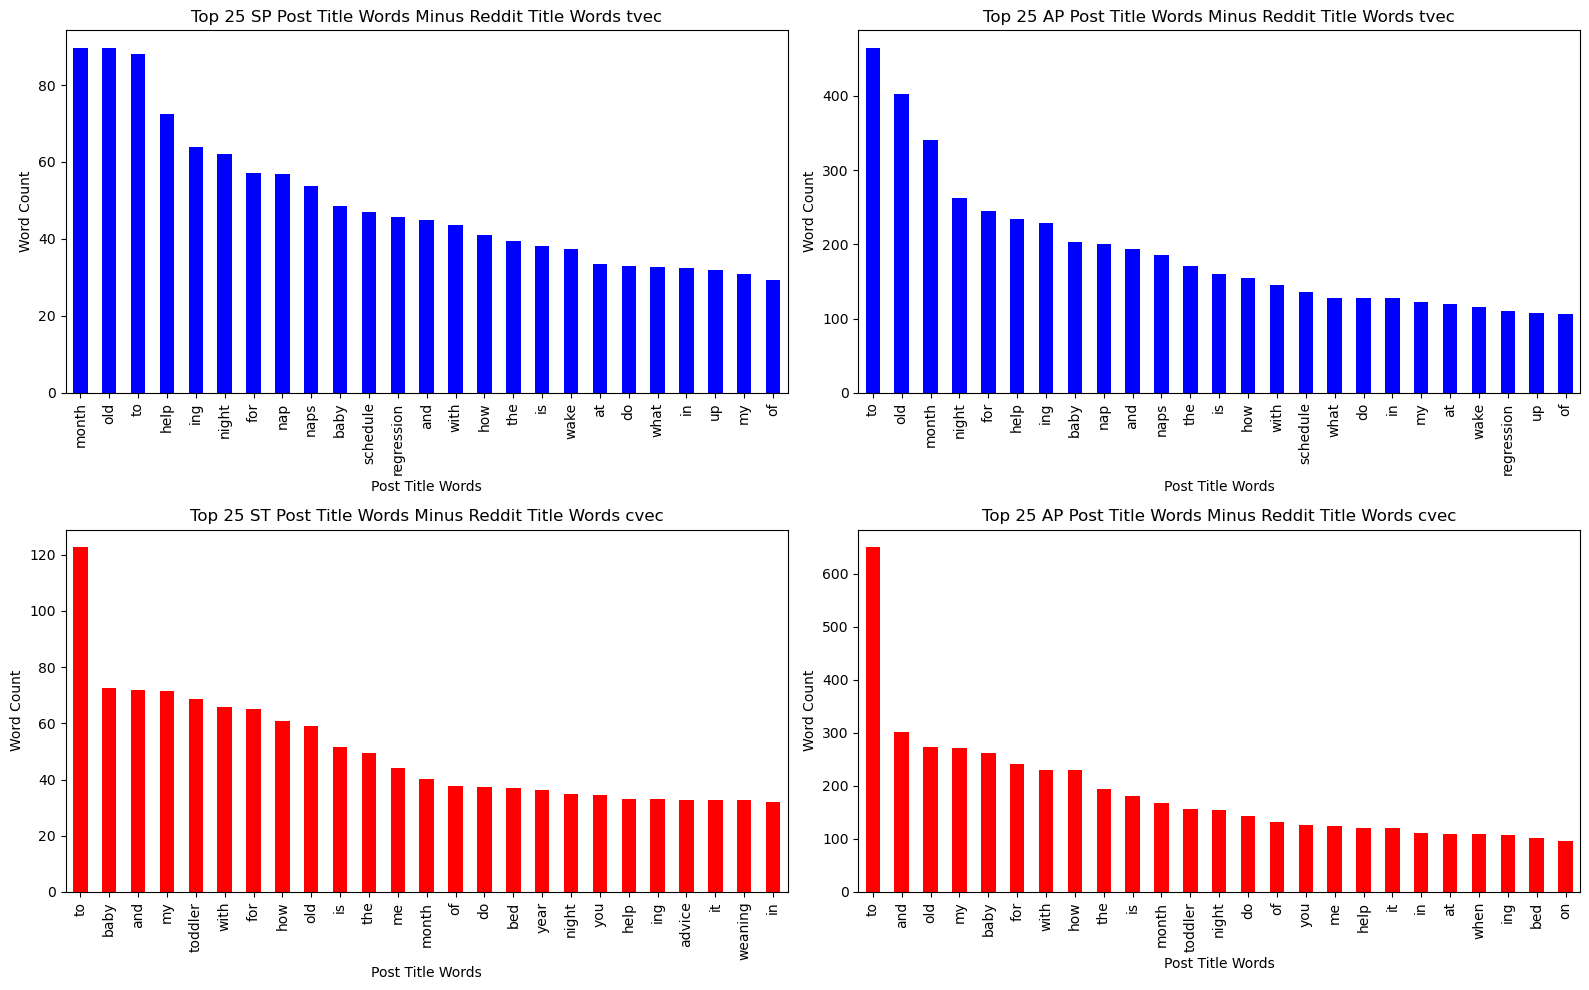

In [406]:
# Looking at the top 25 words for AP tvec and ST tvec Vs AP cvec and ST cvec
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=False)
st_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,0], color='b', kind='bar')
ap_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,0], color='r', kind='bar')

cvec_st_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,1], color='b', kind='bar')
cvec_ap_titlewords_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,1], color='r', kind='bar')

axes[0,0].set_title('Top 25 SP Post Title Words Minus Reddit Title Words tvec')
axes[0,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words tvec')
axes[0,0].set_xlabel('Post Title Words')
axes[0,1].set_xlabel('Post Title Words')
axes[0,0].set_ylabel('Word Count')
axes[0,1].set_ylabel('Word Count')

axes[1,0].set_title('Top 25 ST Post Title Words Minus Reddit Title Words cvec')
axes[1,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words cvec')
axes[1,0].set_xlabel('Post Title Words')
axes[1,1].set_xlabel('Post Title Words')
axes[1,0].set_ylabel('Word Count')
axes[1,1].set_ylabel('Word Count')
plt.tight_layout();

### As before, the cvec has a larger word count. I am not sure of the significance of this but I will try to model with both cvec and tvec to see which is better for classification in my models.  The top 25 Sleep Training words are the same with and without the Subreddit title words in the post title removed for cvec and tvec. This suggests that they may be the same when it comes to classification, but I will test both just to be sure. Lastly, the top 25 words shared between the Attachment Parenting for cvec and tvec with and without the Subreddit title words in the post title removed was increased by 1. Removing the Subreddit title words in the post title may help my tvec classify more accurately in this case.

In [407]:
# Running function to look for same words in each ST cvec and ST tvec top 25
shared_words(st_titlewords_removed_x, cvec_st_titlewords_removed_x)

(['month',
  'old',
  'to',
  'help',
  'ing',
  'night',
  'for',
  'nap',
  'naps',
  'baby',
  'schedule',
  'regression',
  'and',
  'with',
  'how',
  'the',
  'is',
  'wake',
  'at',
  'do',
  'what',
  'in',
  'up',
  'my',
  'of'],
 25)

In [408]:
# Running function to look for same words in each AP cvec and AP tvec top 25
shared_words(ap_titlewords_removed_x, cvec_ap_titlewords_removed_x)

(['to',
  'baby',
  'and',
  'my',
  'toddler',
  'with',
  'for',
  'how',
  'old',
  'is',
  'the',
  'me',
  'month',
  'of',
  'do',
  'bed',
  'night',
  'you',
  'help',
  'ing',
  'it',
  'in'],
 22)

### Now I am going to compare the shared top 25 words shared between keeping stop words and removing stop words  using cvec and tvec in my AP and ST Subreddit categories.

In [409]:
# Instantiating the vectorizer with NLTK stop words removed
cvec = CountVectorizer(stop_words=stopwords.words('english'))

In [410]:
# Fitting cvec and transorming the text
cvec.fit(st_titlewords_removed, ap_titlewords_removed)
cvec_st_title_and_s_words_removed_x = cvec.transform(st_titlewords_removed)
cvec_ap_title_and_s_words_removed_x = cvec.transform(ap_titlewords_removed)

In [411]:
# Creating dataframes from the vectorized text
cvec_st_title_and_s_words_removed_x = pd.DataFrame(cvec_st_title_and_s_words_removed_x.todense(), columns = cvec.get_feature_names_out())
cvec_ap_title_and_s_words_removed_x = pd.DataFrame(cvec_ap_title_and_s_words_removed_x.todense(), columns = cvec.get_feature_names_out())

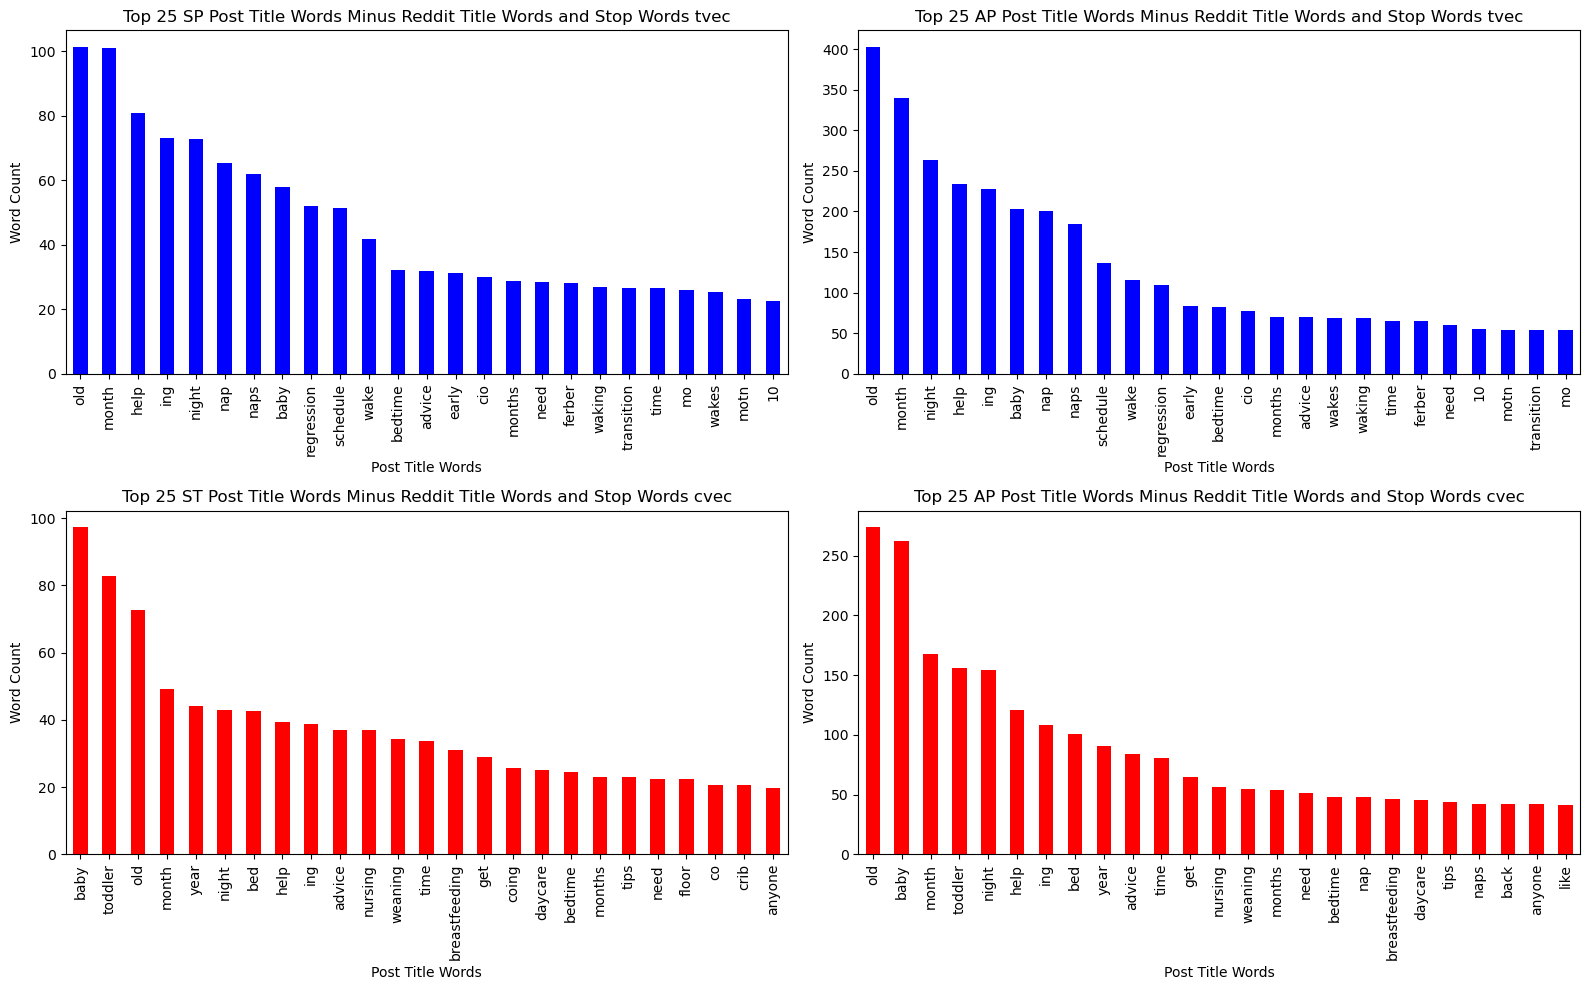

In [412]:
# Looking at the top 25 words for AP tvec and ST tvec Vs AP cvec and ST cvec with stop words removed
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=False)
st_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,0], color='b', kind='bar')
ap_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,0], color='r', kind='bar')

cvec_st_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,1], color='b', kind='bar')
cvec_ap_title_and_s_words_removed_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,1], color='r', kind='bar')

axes[0,0].set_title('Top 25 SP Post Title Words Minus Reddit Title Words and Stop Words tvec')
axes[0,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words and Stop Words tvec')
axes[0,0].set_xlabel('Post Title Words')
axes[0,1].set_xlabel('Post Title Words')
axes[0,0].set_ylabel('Word Count')
axes[0,1].set_ylabel('Word Count')

axes[1,0].set_title('Top 25 ST Post Title Words Minus Reddit Title Words and Stop Words cvec')
axes[1,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words and Stop Words cvec')
axes[1,0].set_xlabel('Post Title Words')
axes[1,1].set_xlabel('Post Title Words')
axes[1,0].set_ylabel('Word Count')
axes[1,1].set_ylabel('Word Count')
plt.tight_layout();

#### Removing the stop words did not make a lot of difference when comparing tvec against cvec. My total number of shared words for cvec was reduced by 1 from before but that was th eonly change. I am beginning to suspect that there will not be much of a difference in my models between using cvec Vs tvec for my specific case.

In [413]:
# Running function to look for same words in each ST cvec and ST tvec top 25
shared_words(st_title_and_s_words_removed_x, cvec_st_title_and_s_words_removed_x)

(['old',
  'month',
  'help',
  'ing',
  'night',
  'nap',
  'naps',
  'baby',
  'regression',
  'schedule',
  'wake',
  'bedtime',
  'advice',
  'early',
  'cio',
  'months',
  'need',
  'ferber',
  'waking',
  'transition',
  'time',
  'mo',
  'wakes',
  'motn',
  '10'],
 25)

In [414]:
# Running function to look for same words in each AP cvec and AP tvec top 25
shared_words(ap_title_and_s_words_removed_x, cvec_ap_title_and_s_words_removed_x)

(['baby',
  'toddler',
  'old',
  'month',
  'year',
  'night',
  'bed',
  'help',
  'ing',
  'advice',
  'nursing',
  'weaning',
  'time',
  'breastfeeding',
  'get',
  'daycare',
  'bedtime',
  'months',
  'tips',
  'need',
  'anyone'],
 21)

#### Lastly, i would like to see the differences between cvec and tvec in terms of lemmatized words. i will lemmatize using both cvec and tvec and compare the common top 25 words again.

In [415]:
# Instantiating the vectorizer with NLTK stop words removed and words lemmatized
cvec = CountVectorizer(stop_words=lem_stopwords, tokenizer = my_lemmatizer)

In [416]:
# Fitting tvec and transorming the text
cvec.fit(st_titlewords_removed, ap_titlewords_removed)
cvec_st_t_and_s_removed_lemmatized_x = cvec.transform(st_titlewords_removed)
cvec_ap_t_and_s_removed_lemmatized_x = cvec.transform(ap_titlewords_removed)

/Users/scottaskinosie/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [417]:
# Creating dataframes from the vectorized text
cvec_st_t_and_s_removed_lemmatized_x = pd.DataFrame(cvec_st_t_and_s_removed_lemmatized_x.todense(), columns = cvec.get_feature_names_out())
cvec_ap_t_and_s_removed_lemmatized_x = pd.DataFrame(cvec_ap_t_and_s_removed_lemmatized_x.todense(), columns = cvec.get_feature_names_out())

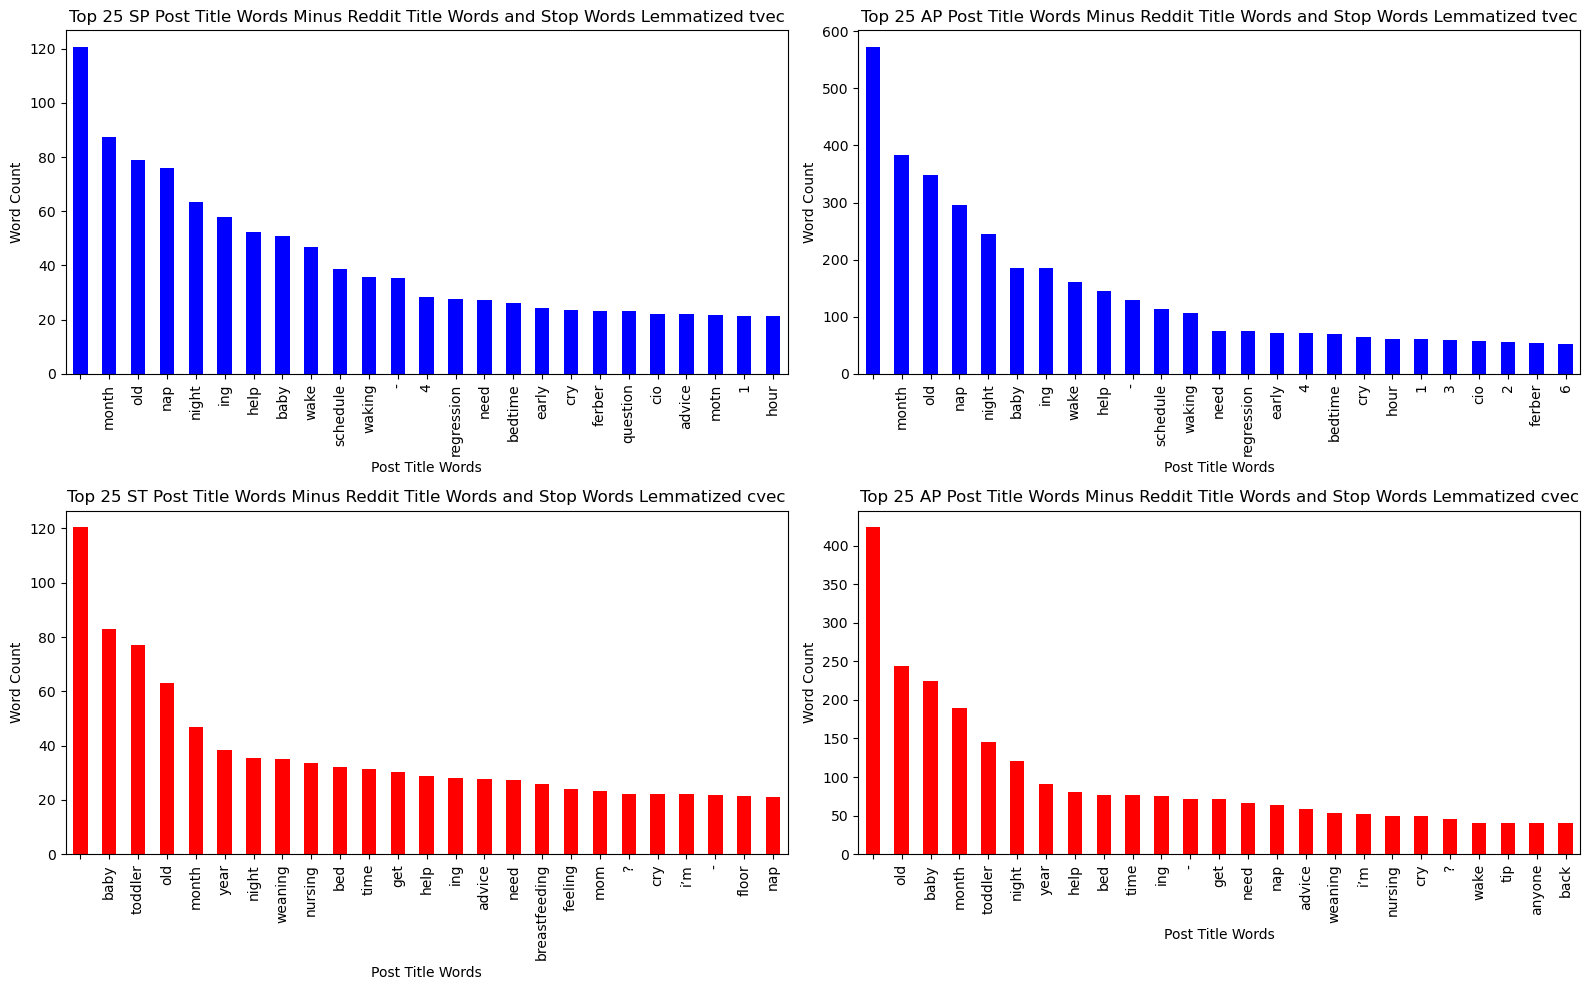

In [418]:
# Looking at the top 25 words for AP tvec and ST tvec Vs AP cvec and ST cvec with stop words removed
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=False)
st_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,0], color='b', kind='bar')
ap_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,0], color='r', kind='bar')

cvec_st_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[0,1], color='b', kind='bar')
cvec_ap_t_and_s_removed_lemmatized_x.sum().sort_values(ascending = False)[0:25].plot(ax=axes[1,1], color='r', kind='bar')

axes[0,0].set_title('Top 25 SP Post Title Words Minus Reddit Title Words and Stop Words Lemmatized tvec')
axes[0,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words and Stop Words Lemmatized tvec')
axes[0,0].set_xlabel('Post Title Words')
axes[0,1].set_xlabel('Post Title Words')
axes[0,0].set_ylabel('Word Count')
axes[0,1].set_ylabel('Word Count')

axes[1,0].set_title('Top 25 ST Post Title Words Minus Reddit Title Words and Stop Words Lemmatized cvec')
axes[1,1].set_title('Top 25 AP Post Title Words Minus Reddit Title Words and Stop Words Lemmatized cvec')
axes[1,0].set_xlabel('Post Title Words')
axes[1,1].set_xlabel('Post Title Words')
axes[1,0].set_ylabel('Word Count')
axes[1,1].set_ylabel('Word Count')
plt.tight_layout();

#### There was a little change between cvec and tvec in terms of common top 25 words between my Subreddit categories. tvec was reduced by 3 common words but cvec stayed the same. This could mean that tvec will result in a better score when using lemmatization than tvec.

In [419]:
# Running function to look for same words in each ST cvec and ST tvec top 25
shared_words(st_t_and_s_removed_lemmatized_x, cvec_st_t_and_s_removed_lemmatized_x)

(['',
  'month',
  'old',
  'nap',
  'night',
  'ing',
  'help',
  'baby',
  'wake',
  'schedule',
  'waking',
  '-',
  '4',
  'regression',
  'need',
  'bedtime',
  'early',
  'cry',
  'ferber',
  'cio',
  '1',
  'hour'],
 22)

In [420]:
# Running function to look for same words in each AP cvec and AP tvec top 25
shared_words(ap_t_and_s_removed_lemmatized_x, cvec_ap_t_and_s_removed_lemmatized_x)

(['',
  'baby',
  'toddler',
  'old',
  'month',
  'year',
  'night',
  'weaning',
  'nursing',
  'bed',
  'time',
  'get',
  'help',
  'ing',
  'advice',
  'need',
  '?',
  'cry',
  'i’m',
  '-',
  'nap'],
 21)

## BAsed on my EDA I have a few predictions on what will work best for my models. The title length and word count are very similar for both Subreddit categories so I do not believe that will be beneficial to my model. I plan to remove the Subreddit category title words from the post titles as they will likely make the categories too easy to predict. I will also remove stop words as my EDA has shown that removing stopwords reduces the common top 25 words shared between the two Subreddit category title posts. I will test my models with lemmatization, even though it seems that will only hinder my models ability to distinguish between the two categories. I will also try 2 grams and 3 grams. the 2 grams look promising as they parse out my categories a little more than without. However, my 3 grams result in more in common words in the list of the top 25 words for each category so I do not have as high of expectations for 3 grams. Lastly, I originally hypothesized that tvec vectorization would be better for my modle than cvec but, after looking at the EDA between cvec and tvec, I am curious to see how cvec performs. The higher word counts may create greater separation between my two categories and give my model better results. 